# 애블레이션 연구(ablation study)란?
- "아이디어를 제거해 봄으로써" 제안한 방법이 어떻게 성능이나 문제에 해결에 효과를 주는지 확인하는 실험
- 예를 들어 residual connection이 없는 일반 네트워크(plain net)와 ResNet을 비교하면서 ResNet이 residual connection을 활용해서 깊은 네트워크를 쌓았을 때, 이를 통한 성능 향상을 얻을 수 있음을 증명하는 것 

- layer가 깊어질수록 좋은 성능을 보여주지만 무조건 깊게만 하면 overfitting과 gradient vanishing 문제가 발생해서 성능이 저하되는 것을 볼 수 있다. 
- 이 문제를 해결하기 위해 residual block(skip connectionㅇ라고도 표현)을 사용한 모델이 바로 **ResNet** 모델이다!!
- 관련 논문 링크 : https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

![model](https://user-images.githubusercontent.com/97458432/159198563-1bfd3b52-4ffa-4f1c-9739-ffb360788606.png)
![VGG-19_ResNet34](https://user-images.githubusercontent.com/97458432/159199787-8fc830f1-8f41-44de-b081-587b2aaebeb9.png)

- 34 layer를 보면 일단 반복되는 블록은 총 4개(conv2_x~5x) 
- 각 블록 안을 살펴보면 필터 사이즈는 3x3으로 동일하고, 채널 수가 2배로 증가하는 것을 볼 수 있다
- 34와 50의 차이는 블록 안에 앞뒤로 1x1 layer의 유무이다  
- conv필터 사이즈는 3x3으로 사용하고 있으며 사진에는 포함되지 않았지만 conv를 하나 지나면 Batchnormalization을 사용
- 한 블럭이 끝나면 maxpooling을 사용하고 마지막 block가 끝나면 average pooling을 사용

![residual](https://user-images.githubusercontent.com/97458432/159200860-4f31ff17-df39-48a1-b2fa-bbc166af8714.png)

- 입력 x가 layer를 지나고 활성함수 relu를 지나 F(x)가 되었을 때 기존의 x(identity)를 다시 더해줘서 "F(x) + x"가 되어 다음 블록의 입력으로 사용된다 
- x를 더해줌으로써 값이 보존되어 깊은 layer에도 좋은 성능을 보일 수 있다. 

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

# 1. 블록 구성하기 
## 1) resnet_block 만들기

In [2]:
# is_50 : True --> resnet_50
# is_plain :True --> no skip connection    
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):

    # 입력 레이어
    x = input_layer

    if not is_50:  # ResNet 34일 경우

    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)  # conv 사이에 Batchnormalization
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
        
         # skip connection일 경우 
        if not is_plain:
             # tf.TensorShape의 as_list() 메서드는 텐서의 형태를 리스트로 반환
            identity_channel = identity.shape.as_list()[-1]   

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            
            # skip connection, x와 identity 더해서 입력값 만든다 
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    
    else :   # ResNet 50일 경우 1x1, 3x3, 1x1 반복
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(    # 3번째 Conv layer
            filters=channel * 4,    # 채널 수 4배로 늘리기 
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass

    # Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

## 2) build_resnet

In [3]:
def build_resnet(input_shape=(224, 224, 3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=2,is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 2     # 개와 고양이이므로 2개
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer

    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    

    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    # 어느 숫자든 괜찮음
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

## 손실함수
- 머신러닝 또는 딥러닝 모델의 출력값과 사용자가 원하는 출력값의 오차를 의미
- 손실함수는 정답(y)과 예측(^y)을 입력받아 실숫값으로 점수를 만듦
- 손실함수의 함수값이 최소가 되도록 하는 가중치(weight)와 편향(bias)을 찾는 것이 목표


---

### **1. binary_crossentropy(이항 교차 엔트로피)**
- y값이 이진 분류기(ex. 0, 1)를 훈련할 때 자주 사용 
- 활성화 함수 : sigmoid 사용(출력값은 0~1 사이)

### **2. categorical_crossentropy(범주형 교차 엔트로피)**
- 출력을 클래스 소속 확률에 대한 예측으로 이해할 수 있는 문제에서 사용
- 레이블 y 클래스가 2개 이상일 경우 사용
- 활성화 함수 : softmax(모든 벡터 요소의 값은 0~1 사이의 값이 나오고 모든 합이 1이 됨)
- 라벨이 (0,0,1,0,0)과 같은 one-hot encoding된 형태로 제공될 때 사용 가능 

### **3. sparse_categorical_crossentropy**
- 범주형 교차 엔트로피와 동일하게 멀티 클래스 분류에 사용
- one-hot encoding 된 상태일 필요 없이 정수 인코딩 된 상태에서 수행 가능
- 라벨이 (1,2,3,4) 이런식으로 정수 형태일 때 사용 

### **4. 평균 제곱 오차 손실(means squared error, MSE)**
- 정답과 예측이 연속값인 회귀 문제에서 사용하는 손실함수
- MSE가 크다는 것은 평균 사이에서 차이가 크다는 뜻
- MSE가 작다는 것은 데이터와 평균 사이의 차이가 작다는 뜻
- 즉 MSE는 데이터가 평균으로부터 얼마나 떨어져있나를 보여주는 손실함수
- 연속형 데이터를 사용할 때 주로 사용(주식 가격 예측 등)


---
### binary, categorical, saparse_categorical_crossentropy 비교.
- 결론적으로 둘의 차이는 output layer가 sigmoid이냐 softmax이냐이다.
- 내가 가진 label 값이 0 or 1 이면서 sigmoid_cross_entropy를 loss로 하고 싶으면 binary_crossentropy 를 쓰면 된다.
내가 가진 라벨이 [0,1] or [1,0] 의 형태이면서 softmax_cross_entropy를 loss로 하고자 할 때는 categorical_crossentropy를 쓰면 된다.
- **label 이 0 or 1 인데 softmax_cross_entropy를 쓰고싶으면 sparse_categorical_crossentropy를 쓰면 된다.**





In [4]:
resnet_34 = build_resnet(is_50 = False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  832         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

# 2. 데이터셋 불러오기(cats_vs_dogs)

In [6]:
# (ds_train, ds_test, ds_val)까지 3개로 나눠서 받고 테스트 할때와 검증할 때 데이터셋 따로 쓰면 됨 
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],   # train셋을 적절한 비율로 3 부분으로 나눌 수 있음 
    shuffle_files=True, 
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteKU4SWG/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [7]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)
print()
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


# 3. 데이터 전처리
- 모델에 넣기 전에 각 채널별 최댓값인 255로 정규화를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만들어 줌 
- Data Normalization을 하는 이유는 머신러닝에서 scale이 큰 feature의 영향이 비대해지는 것을 방지하고, 딥러닝에서 Local optimum에 빠질 위험을 줄이는(학습 속도 향상) 것

In [8]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    
    # resnet에 224x224로 넣어줘야 하므로 사이즈 지정
    image = tf.image.resize(image, (224, 224))
    
    return tf.cast(image, tf.float32) / 255., label

In [9]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
ds_info.features["label"].names

['cat', 'dog']

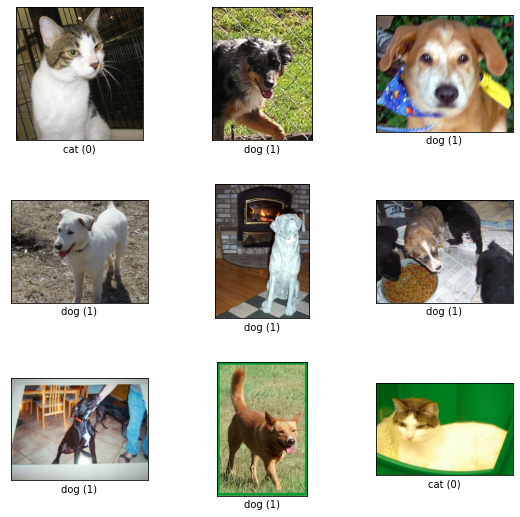

In [11]:
fig = tfds.show_examples(ds_train, ds_info)

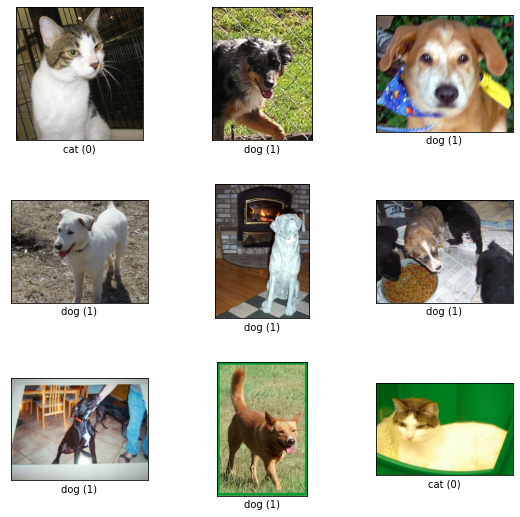

In [12]:
fig = tfds.show_examples(ds_train, ds_info)

In [13]:
BATCH_SIZE = 32
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True, batch_size=BATCH_SIZE)

# 4. 모델 학습
## 1) resnet_34

In [14]:
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  832         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [15]:
EPOCH = 10

resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate =0.001),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 110s 154ms/step - loss: 0.8777 - accuracy: 0.5736 - val_loss: 0.6721 - val_accuracy: 0.6071
Epoch 2/10
581/581 [==============================] - 92s 158ms/step - loss: 0.6107 - accuracy: 0.6683 - val_loss: 0.6466 - val_accuracy: 0.6388
Epoch 3/10
581/581 [==============================] - 91s 157ms/step - loss: 0.5560 - accuracy: 0.7170 - val_loss: 0.5817 - val_accuracy: 0.6933
Epoch 4/10
581/581 [==============================] - 91s 157ms/step - loss: 0.4929 - accuracy: 0.7643 - val_loss: 0.4901 - val_accuracy: 0.7763
Epoch 5/10
581/581 [==============================] - 91s 157ms/step - loss: 0.4355 - accuracy: 0.8012 - val_loss: 0.7821 - val_accuracy: 0.7425
Epoch 6/10
581/581 [==============================] - 91s 157ms/step - loss: 0.3649 - accuracy: 0.8414 - val_loss: 0.4766 - val_accuracy: 0.8110
Epoch 7/10
581/581 [==============================] - 91s 157ms/step - loss: 0.3212 - accuracy: 0.8612 - val_loss: 0.4777 - val_a

1. sparse_categorical_crossentropy로 먼저 실행해봤는데 정확도가 높게 나왔음 
2. 지금하는 데이터셋이 고양이와 개 2종류만 분류하는 모델이여서 binary_crossentropy로 했을 경우 어떨지 궁금했음
3. binary의 경우 출력값이 1개만 나와야 해서 build_resnet 함수로 다시 올라가서 마지막 dense 층의 num_classes를 1로 바꿔야 함, 활성화 함수는 sigmoid 사용
4. 변경 후 다시 런타임 실행해서 확인하였는데 val_accuracy 값이 0.5 이상이 되지 않아서 에폭 14쯤에서 중단 
5. 원래 loss인 sparse_categorical_crossentropy로 사용해서 각각의 비율로 나타내는 것으로 변경 
6. epoch은 10이면 충분해서 10까지만 실행 
7. optimizer는 Adam, lr = 0.001로 변경
8. lr로 하면 바꾸라고 해서 learning_rate로 바꿈 


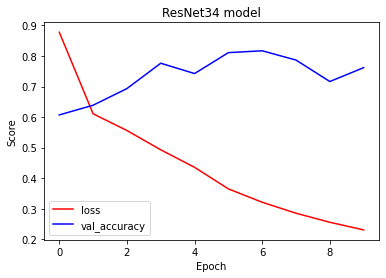

In [16]:
# 위의 데이터 확인차 그려보기 
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_34.history['val_accuracy'], 'b')

plt.title('ResNet34 model')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_accuracy'], loc='best')
plt.show()

## 2) resnet_50

In [17]:
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 112, 112, 64  832         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 112, 112, 64  256        ['conv2d_1[0][0]']               
 ormalization)                  )                                                           

# 이미 여기에서부터 모델 ResNet 34와 50이 똑같이 나옴 
- 위에 함수 부분에서 이리저리 고쳐 봤지만 수정하지 못함
- 내가 봤을 땐 제대로 적었고 True False로 구분이 되면서 실행이 되어야 하는데 계속 기본 베이스로만 동일하게 나오고 있음
- 이걸 바로 잡기 위해 하루종일 매달렸지만 잡지 못했고 이미 제출 시간이 얼마 남지 않아서 그냥 뒤에 쭉 진행 함

In [18]:
EPOCH = 10

resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate =0.001),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 100s 158ms/step - loss: 0.8886 - accuracy: 0.6039 - val_loss: 0.6600 - val_accuracy: 0.6239
Epoch 2/10
581/581 [==============================] - 91s 157ms/step - loss: 0.5714 - accuracy: 0.7036 - val_loss: 0.5900 - val_accuracy: 0.7289
Epoch 3/10
581/581 [==============================] - 91s 157ms/step - loss: 0.5179 - accuracy: 0.7429 - val_loss: 0.9944 - val_accuracy: 0.7392
Epoch 4/10
581/581 [==============================] - 91s 157ms/step - loss: 0.4456 - accuracy: 0.7946 - val_loss: 0.4536 - val_accuracy: 0.8123
Epoch 5/10
581/581 [==============================] - 91s 157ms/step - loss: 0.3930 - accuracy: 0.8244 - val_loss: 0.4303 - val_accuracy: 0.8295
Epoch 6/10
581/581 [==============================] - 91s 157ms/step - loss: 0.3518 - accuracy: 0.8492 - val_loss: 0.5099 - val_accuracy: 0.7776
Epoch 7/10
581/581 [==============================] - 91s 157ms/step - loss: 0.2976 - accuracy: 0.8743 - val_loss: 1.1582 - val_a

## 3) plain_resnet_34

In [20]:
plain_resnet_34 = build_resnet(is_50 = False, is_plain = True)
plain_resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 112, 112, 64  832         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 112, 112, 64  256        ['conv2d_2[0][0]']               
 ormalization)                  )                                                           

In [21]:
EPOCH = 10

plain_resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate =0.001),
    metrics=['accuracy'],
)

history_p34 = plain_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 100s 158ms/step - loss: 0.8433 - accuracy: 0.5940 - val_loss: 0.6679 - val_accuracy: 0.6330
Epoch 2/10
581/581 [==============================] - 91s 157ms/step - loss: 0.5833 - accuracy: 0.6947 - val_loss: 0.5972 - val_accuracy: 0.6718
Epoch 3/10
581/581 [==============================] - 91s 157ms/step - loss: 0.5288 - accuracy: 0.7344 - val_loss: 0.6688 - val_accuracy: 0.7056
Epoch 4/10
581/581 [==============================] - 91s 157ms/step - loss: 0.4948 - accuracy: 0.7628 - val_loss: 0.4943 - val_accuracy: 0.7711
Epoch 5/10
581/581 [==============================] - 92s 158ms/step - loss: 0.4348 - accuracy: 0.7996 - val_loss: 0.4543 - val_accuracy: 0.7953
Epoch 6/10
581/581 [==============================] - 92s 158ms/step - loss: 0.3849 - accuracy: 0.8260 - val_loss: 0.5236 - val_accuracy: 0.7841
Epoch 7/10
581/581 [==============================] - 91s 157ms/step - loss: 0.3421 - accuracy: 0.8499 - val_loss: 0.4747 - val_a

## 4) plain_resnet_50

In [22]:
plain_resnet_50 = build_resnet(is_50 = True, is_plain = True)
plain_resnet_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 112, 112, 64  832         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_51 (BatchN  (None, 112, 112, 64  256        ['conv2d_3[0][0]']               
 ormalization)                  )                                                           

In [23]:
EPOCH = 10

plain_resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate =0.001),
    metrics=['accuracy'],
)

history_p50 = plain_resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),   #ds_val을 사용해서 검증해볼 수 있다. 처음 데이터 로드 할 때 val도 따로 구분해서 스플릿 해야함 
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 100s 158ms/step - loss: 0.8064 - accuracy: 0.5990 - val_loss: 0.7681 - val_accuracy: 0.5642
Epoch 2/10
581/581 [==============================] - 91s 157ms/step - loss: 0.5836 - accuracy: 0.6948 - val_loss: 0.6130 - val_accuracy: 0.6560
Epoch 3/10
581/581 [==============================] - 91s 157ms/step - loss: 0.5215 - accuracy: 0.7483 - val_loss: 0.7759 - val_accuracy: 0.7457
Epoch 4/10
581/581 [==============================] - 91s 157ms/step - loss: 0.4818 - accuracy: 0.7747 - val_loss: 0.5840 - val_accuracy: 0.7315
Epoch 5/10
581/581 [==============================] - 91s 157ms/step - loss: 0.4231 - accuracy: 0.8098 - val_loss: 0.4602 - val_accuracy: 0.7832
Epoch 6/10
581/581 [==============================] - 91s 157ms/step - loss: 0.3739 - accuracy: 0.8339 - val_loss: 0.7072 - val_accuracy: 0.8071
Epoch 7/10
581/581 [==============================] - 92s 158ms/step - loss: 0.3231 - accuracy: 0.8617 - val_loss: 0.3291 - val_a

# 5. 시각화를 통해 모델 비교 
- 훈련 손실 비교
- 검증 정확도 비교

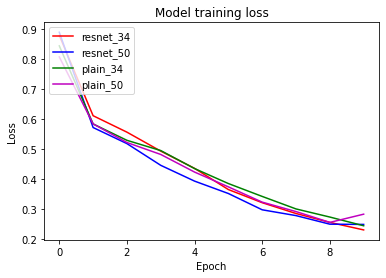

In [24]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.plot(history_p34.history['loss'], 'g')
plt.plot(history_p50.history['loss'], 'm')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='upper left')
plt.show()

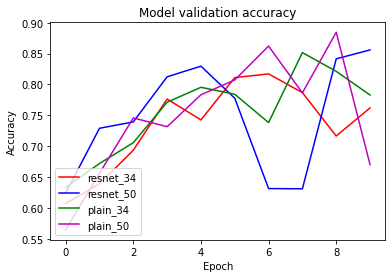

In [25]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.plot(history_p34.history['val_accuracy'], 'g')
plt.plot(history_p50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='lower left')
plt.show()

위의 시각화는 결국 ResNe_34에 대한 결과값이다. 두번째 정확도 그림이 좀 이상한데 
## 결국 다 똑같은 모델이다 

In [ ]:
# 이 부분 확인해보기 
# loss, acc = resnet_50.evaluate(ds_test)

In [ ]:
# 먼저 구글 마운트 하고 실행 
# resnet_50.save('cat_dog_model')

# 회고 
- 이번에 처음으로 고잉디퍼를 진행하였는데 익스 할 때 보다 훨~~~씬 어렵지만 배우고 기억에 남는 점이 많았다
- 코드를 하나씩 뜯어서 보니 처음 데이터 셋은 많은 클래스를 가지고 있어서 손실 함수를 sparse_categorical_crossentropy로 사용하고 one-hot 인코딩을 할 필요 없이 사용 가능 하므로 많이 사용된다고 하였다. 
- 이전 노드들도 생각해보니 다중 분류 시 sparse_categorical_crossentropy를 사용했었는데 그때는 그냥 그런가보다 하고 넘어갔었지만 이번에 적용시키기 위해서 많이 배우게 되었다
- 이번에 사용한 데이터셋은 고양이와 개 두 가지만 분류하는 모델을 만드는 것이라서 binary 크로스엔트로피를 사용해서 쓰려고 손실함수만 바꾸니 제대로 작동하지 않았다 
    - binary의 경우 1개의 결과값이 0~1사이 숫자만 나오므로 sigmoid 활성화 함수를 사용
    - binary를 처음 쓸 때 내 생각은 2개가 확률로 나오는 줄 알고 output도 2개가 나오도록 했었다(고양이 0.7 / 개 0.3) 그런데 shape이 맞지 않다는 에러가 떠서 수완님께 물어보니 binary는 1개만 나온다고 해서 이때부터 찾아보고 공부하기 시작했다. 그래서 손실함수와 활성화 함수를 어떻게 구분해서 사용해야 하는지 알게 되었다
- 이번에 하나씩 모댈을 만들면서 이전에 썼던 건 정말 간편한 거였구나 라고 새삼 한번 더 느끼게 되었고 conv block의 구조에 대해서 좀 더 깊게 알 수 있었다
- 모델 저장까지 해보려고 야심차게 마음 먹었는데 모델이 제대로 만들어지지 않아서 거기까지 진도를 나갈 수 없었다



# 참고 사이트
- Pooling 개념 한번 더 잡기 : https://supermemi.tistory.com/16
- resnet-36, resnet-50 구현 : https://hwanny-yy.tistory.com/12?category=980295
- Tensorflow 자주 사용하는 Tensor 함수 : https://acdongpgm.tistory.com/222
- keras Doc : https://keras.io/ko/models/sequential/
- binary, categorical, sparse_categorical_crossentropy 차이 : https://han-py.tistory.com/266
- 손실함수 : https://sefer-raziel.tistory.com/192